# Process the Hydrographic Data into Parquet

The NOAA National Water Model Retrospective dataset is a 44-year (February 1979 through January 2023) retrospective simulation using version 3.0 of the National Water Model. This is hourly streamflow data from all streams and rivers in the U.S. by `COMID` (feature id) id. We will be subsetting streams by HUC-2 Regions.  The COMID ids will be extracted from shapefiles for the HUC-2 region and saved as a parquet file (more efficient = smaller than csv). This file will be read in later when the feature ids are needed. 

## HUC-2 Region 17: Pacific Northwest

Region 17 includes the Pacific Northwest, covering most of Washington, Oregon, and parts of Idaho, Montana, and California. The region is dominated by rivers that drain westward into the Pacific Ocean, including the Columbia, Willamette, and Snake River systems. These watersheds are shaped by the Cascade and Rocky Mountains, supporting a variety of landscapes from coastal rainforests to interior plateaus. The region plays a critical role in hydropower, fisheries, and agriculture across the Northwest.

## Source and Description of Hydrography Data

The shapefile used in this project is derived from the [EPA NHDPlus Version 2.1 Pacific Northwest Vector Processing Unit (VPU) 17](https://www.epa.gov/waterdata/nhdplus-pacific-northwest-data-vector-processing-unit-17), specifically from the archive: `NHDPlusV21_PN_17_NHDSnapshot_08.7z`.

This archive contains a snapshot of the National Hydrography Dataset (NHD) flowlines for Hydrologic Region 17 (HUC-2) plus a few other subregions from other HUC-2 regions. The NHDPlusV2.1 dataset integrates high-resolution stream and river centerlines with attributes such as:

- `COMID` (unique feature ID)
- `FTYPE` (e.g., StreamRiver, CanalDitch, ArtificialPath)
- `LENGTHKM` (feature length in kilometers)
- `REACHCODE` (hierarchical hydrologic code the first 4 digits of which are the HUC-4 code)
- `GNIS_NAME` (official stream name)

## HUC-4 Subregions Included in VPU 17

`NHDPlusV21_PN_17_NHDSnapshot_08.7z` represents Hydrologic Region 17 (HUC-2) plus a few other HUC4 subregions that are not in Hydrologic Region 17. Here are the HUC2 subregions included in VPU 17.


| HUC-4 | Name                        | Region Description                                                                                 |
|-------|-----------------------------|------------------------------------------------------------------------------------------------------|
| 1601  | Bear              | The Bear River Basin. Idaho, Utah, Wyoming.  Drains into Great Salt Lake. Excluded.                  |
| 1604  | Black Rock Desert-Humboldt               | The Humboldt River Basin, the Black Rock Desert, and other closed basins that discharge into Northwestern Nevada. Excluded.                    |
| 1701      | Kootenai-Pend Oreille-Spokane | Includes Kootenai, Pend Oreille, and Spokane River Basins in ID, MT, WA. Drains to Columbia River and onto Pacific.         |
| 1702      | Upper Columbia                | The Columbia River Basin above the confluence with the Snake River Basin, excluding the Yakima River Basin. Drains to Pacific.            |
| 1703      | Yakima                        | Yakima River Basin in central Washington. Drains to Columbia River and onto Pacific.                           |
| 1704      | Upper Snake                   | Snake River Basin to and including Clover Creek. Drains to Columbia River and onto Pacific.        |
| 1705      | Middle Snake                  | The Snake River Basin below the Clover Creek Basin to Hells Canyon Dam. Drains to Columbia River and onto Pacific.              |
| 1706      | Lower Snake                   | The Snake River Basin below Hells Canyon Dam to its confluence with the Columbia River. Drains to Pacific.    |
| 1707      | Middle Columbia | The Columbia River Basin below the confluence with the Snake River Basin to Bonneville Dam. Drains to Pacific. |
| 1708      | Lower Columbia                | The Columbia River Basin below Bonneville Dam, excluding the Willamette River Basin. Drains to Pacific.   |
| 1709      | Willamette                    | Willamette River Basin in western Oregon. Drains to Columbia and onto Pacific.      |
| 1710      | Oregon-Washington Coastal   | Connect directly to the Pacific.   |
| 1711      | Puget Sound                   | Drainage to Puget Sound and nearby waters in Washington  |
| 1712      | Oregon closed basins            | The drainage of the Great Basin that discharges into the state of Oregon.   |
| 1801      | Klamath-Northern California Coastal    | Excluded. Included in WR18. |

*From "Boundary Descriptions and Names of Regions, Subregions, Accounting Units and Cataloging Units from the 1987 USGS Water-Supply Paper 2294" https://water.usgs.gov/GIS/huc_name.html. Note some HUC numbers might have changed so double check this information. https://nas.er.usgs.gov/hucs.aspx*


*Acknowledgment: Data provided by the U.S. Environmental Protection Agency (EPA) and U.S. Geological Survey (USGS) as part of the NHDPlusV2 dataset.*

## Data aquisition

The zip file `NHDPlusV21_PN_17_NHDSnapshot_08.7z` was downloaded, unzipped and these files in the Hydrography directory were kept: NHDFlowline.shp, NHDFlowline.dbf, NHDFlowline.shx, NHDFlowline.prj.

First I will convert to a geoparquet file which will be more efficient space-wise. I will keep this with the processed streamflow data for completeness. If I were only working with Python, the following code would work, but R is really picky with the geometries and I had to really flatten the geometry to get R to use the parquet file.


In [9]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Measured \\(M\\) geometry types are not supported.*",
    category=UserWarning,
    module="pyogrio.raw"
)
import geopandas as gpd

gdf = gpd.read_file("../HUC2-17/NHDFlowline.shp")

In [2]:
# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str[:4]
gdf["HUC4"].unique()

array(['0904', '1003', '1601', '1604', '1701', '1702', '1703', '1704',
       '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712',
       '1801'], dtype=object)

In [10]:
# But R complains about malformed geometries so I had to get ChatGPT to help
# me make the geometry 2D
import geopandas as gpd
from shapely.geometry import (
    Point, LineString, Polygon,
    MultiPoint, MultiLineString, MultiPolygon,
)
from shapely.geometry.base import BaseGeometry

def drop_z_coords(geom: BaseGeometry):
    if geom.is_empty or geom is None:
        return geom

    if isinstance(geom, Point):
        return Point(geom.x, geom.y)

    elif isinstance(geom, LineString):
        return LineString([(x, y) for x, y, *_ in geom.coords])

    elif isinstance(geom, Polygon):
        exterior = [(x, y) for x, y, *_ in geom.exterior.coords]
        interiors = [
            [(x, y) for x, y, *_ in ring.coords]
            for ring in geom.interiors
        ]
        return Polygon(exterior, interiors)

    elif isinstance(geom, MultiPoint):
        return MultiPoint([drop_z_coords(g) for g in geom.geoms])

    elif isinstance(geom, MultiLineString):
        return MultiLineString([drop_z_coords(g) for g in geom.geoms])

    elif isinstance(geom, MultiPolygon):
        return MultiPolygon([drop_z_coords(g) for g in geom.geoms])

    else:
        raise ValueError(f"Unsupported geometry type: {type(geom)}")

gdf["geometry"] = gdf["geometry"].apply(drop_z_coords)

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str[:4]

# Fix crs
gdf = gdf.to_crs("EPSG:4269")

# Exclude; these are not in Region 17
gdf_filtered = gdf[~gdf["HUC4"].isin(['0904', '1003', '1601', '1604', '1801'])]

# Fix crs
gdf.set_crs("EPSG:4269", inplace=True)

# Save clean 2D geometry
gdf_filtered.to_parquet("../flowline/WR_17_Flowline.parquet", index=False)


In [6]:
gdf_filtered["HUC4"].unique()

array(['1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708',
       '1709', '1710', '1711', '1712'], dtype=object)

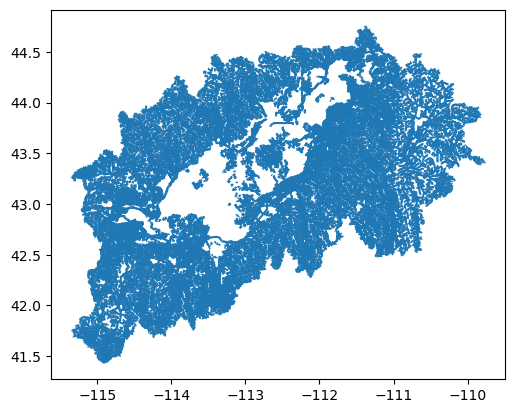

In [11]:
# test
import geopandas as gpd
gdf = gpd.read_parquet("../flowline/WR_17_Flowline.parquet")
gdf_small = gdf[gdf["HUC4"] == "1704"]
gdf_small.plot();


## Create a map

/tmp/ipykernel_805/965679758.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(huc4_list))


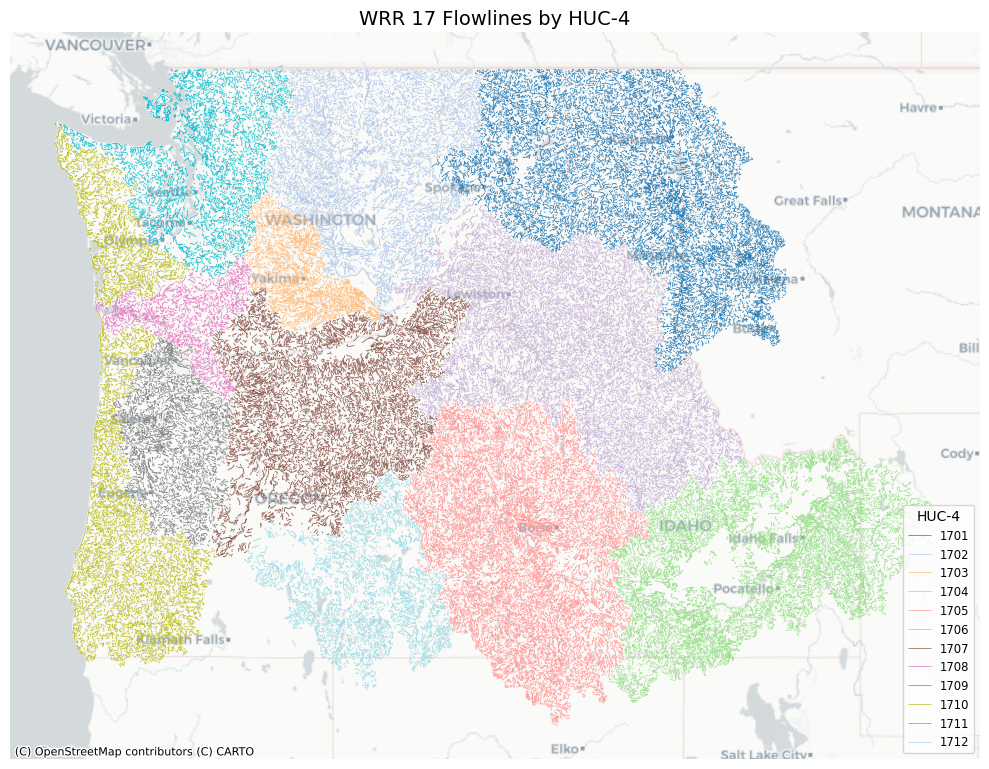

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load the GeoParquet file
gdf = gpd.read_parquet("../flowline/WR_17_Flowline.parquet")

# Set CRS if missing
if gdf.crs is None:
    gdf.set_crs("ESRI:102039", inplace=True)

# Clean up geometries
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

# Reproject to Web Mercator
gdf = gdf.to_crs("EPSG:3857")

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str.slice(0, 4)

# Optional: sample for plotting efficiency
gdf_sampled = gdf.sample(frac=0.5, random_state=42)

# Get unique HUC-4s
huc4_list = sorted(gdf_sampled["HUC4"].unique())

# Create a colormap
cmap = cm.get_cmap("tab20", len(huc4_list))
color_map = {huc4: cmap(i) for i, huc4 in enumerate(huc4_list)}

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

for huc4 in huc4_list:
    subset = gdf_sampled[gdf_sampled["HUC4"] == huc4]
    subset.plot(ax=ax, color=color_map[huc4], linewidth=0.5, label=huc4)

ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title("WRR 17 Flowlines by HUC-4", fontsize=14)
ax.axis("off")
ax.legend(title="HUC-4", loc="lower right", fontsize="small", title_fontsize="medium")
plt.tight_layout()

plt.savefig("../metadata/wr17_map.png", dpi=300, bbox_inches="tight")
plt.show()


## Save the data frame of feature ids

In [13]:
import geopandas as gpd

gdf = gpd.read_parquet("../flowline/WR_17_Flowline.parquet")

# Drop geometry if you don't need it
df = gdf.drop(columns="geometry")

df.to_parquet("../flowline/WR_17_metadata.parquet")

In [14]:
df

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,HUC4
0,22882601,2001-02-28,Medium,785256,Indian Creek,6.873,17010101000001,With Digitized,0,StreamRiver,46006,0.078793,True,0,1701
1,22877591,2005-09-06,Medium,384301,Kootenai River,0.247,17010101000002,With Digitized,120049061,ArtificialPath,55800,0.002475,True,0,1701
2,22877595,2001-02-28,Medium,391351,Star Creek,1.999,17010101000003,With Digitized,0,StreamRiver,46006,0.025318,True,0,1701
3,22877593,2001-02-28,Medium,391351,Star Creek,0.055,17010101000003,With Digitized,120049061,ArtificialPath,55800,0.000667,True,0,1701
4,22877597,2001-02-28,Medium,391351,Star Creek,0.947,17010101000004,With Digitized,0,StreamRiver,46006,0.012066,True,0,1701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272319,24545035,2005-08-27,Medium,None,None,1.549,17120009001540,Uninitialized,0,StreamRiver,46003,0.018321,True,0,1712
272320,24545037,2005-08-27,Medium,None,None,2.899,17120009001541,Uninitialized,0,StreamRiver,46003,0.032696,True,0,1712
272321,24545039,2005-08-27,Medium,None,None,2.847,17120009001542,Uninitialized,0,StreamRiver,46003,0.029718,True,0,1712
272322,24545041,2005-08-27,Medium,None,None,2.005,17120009001543,Uninitialized,0,StreamRiver,46003,0.020023,True,0,1712


## Test that it reads in ok

In [16]:
import pandas as pd

# Load the full parquet file
df = pd.read_parquet("../flowline/WR_17_metadata.parquet")

# Filter where FTYPE is exactly "StreamRiver"
streamriver_df = df[df["FTYPE"] == "StreamRiver"]

# Extract COMIDs (aka feature_ids)
feature_ids = streamriver_df["COMID"].unique()

len(feature_ids)

232303

## Summary 

The original shapefiles were processed into a geoparquet that is smaller in size. A parquet file with just the COMID id metadata is saved also as parquet file. These files will appear in the GCP bucket as follows.